In [2]:
import gym
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


def policy_evaluation(env, policy, V, theta=1e-5, gamma=0.9):
    n_states = env.observation_space.n
    while True:
        delta = 0
        for s in range(n_states):
            v = V[s]
            v_new = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_s, reward, done in env.P[s][a]:
                    if done:
                        v_new += action_prob * prob * reward
                    else:
                        v_new += action_prob * prob * (reward + gamma * V[next_s])
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        if delta < theta:
            break
    return V

def policy_improvement(env, V, policy, gamma=0.9):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy_stable = True
    for s in range(n_states):
        old_action = np.argmax(policy[s])
        action_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_s, reward, done in env.P[s][a]:
                if done:
                    action_values[a] += prob * reward
                else:
                    action_values[a] += prob * (reward + gamma * V[next_s])
        best_action = np.argmax(action_values)
        policy[s] = np.eye(n_actions)[best_action]
        if old_action != best_action:
            policy_stable = False
    return policy, policy_stable

def policy_iteration(env, gamma=0.9, theta=1e-5):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy = np.ones((n_states, n_actions)) / n_actions
    V = np.zeros(n_states)
    while True:
        V = policy_evaluation(env, policy, V, theta, gamma)
        new_policy, stable = policy_improvement(env, V, policy.copy(), gamma)
        if stable:
            break
        policy = new_policy
    return policy, V

def run_episode(env, policy):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(policy[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
    return total_reward

# Create the environment
env = gym.make('FrozenLake-v1', is_slippery=False)

# Run policy iteration
optimal_policy, optimal_V = policy_iteration(env)

# Test the policy
success_rate = np.mean([run_episode(env, optimal_policy) for _ in range(100)])
print(f"Success Rate: {success_rate * 100}%")

Success Rate: 100.0%


In [20]:
import numpy as np
import itertools
from scipy.stats import poisson
import matplotlib.pyplot as plt

class JacksCarRentalEnv:
    def __init__(self, max_cars=20, max_move=5, rental_reward=10, move_cost=2, discount=0.9):
        self.max_cars = max_cars  # Max cars per location
        self.max_move = max_move  # Max cars that can be moved overnight
        self.rental_reward = rental_reward  # Reward per rented car
        self.move_cost = move_cost  # Cost per moved car
        self.discount = discount  # Discount factor for future rewards
        
        # Poisson parameters for rental requests and returns
        self.rental_lambda = [3, 4]  # Expected rentals at locations 1 & 2
        self.return_lambda = [3, 2]  # Expected returns at locations 1 & 2
        
        # Precompute Poisson probabilities to improve performance
        self.poisson_probs = self.precompute_poisson_probs()

    def precompute_poisson_probs(self):
        """Precompute Poisson probabilities for rentals and returns up to max_cars."""
        poisson_probs = {}
        for loc in range(2):  # Two locations
            for kind, lam in zip(["rental", "return"], [self.rental_lambda[loc], self.return_lambda[loc]]):
                probs = np.array([poisson.pmf(n, lam) for n in range(self.max_cars + 1)])
                probs[-1] += 1 - np.sum(probs)  # Handle tail probability
                poisson_probs[(loc, kind)] = probs
        return poisson_probs

    def step(self, state, action):
        """Compute the next state, reward, and transition probability."""
        cars_loc1, cars_loc2 = state
        cars_loc1 = min(cars_loc1 - action, self.max_cars)
        cars_loc2 = min(cars_loc2 + action, self.max_cars)

        total_reward = -self.move_cost * abs(action)  # Cost for moving cars
        transition_probs = {}

        for rentals1 in range(self.max_cars + 1):
            for rentals2 in range(self.max_cars + 1):
                p_rentals1 = self.poisson_probs[(0, "rental")][rentals1]
                p_rentals2 = self.poisson_probs[(1, "rental")][rentals2]
                
                actual_rentals1 = min(cars_loc1, rentals1)
                actual_rentals2 = min(cars_loc2, rentals2)
                
                reward = (actual_rentals1 + actual_rentals2) * self.rental_reward
                new_cars_loc1 = cars_loc1 - actual_rentals1
                new_cars_loc2 = cars_loc2 - actual_rentals2

                for returns1 in range(self.max_cars + 1):
                    for returns2 in range(self.max_cars + 1):
                        p_returns1 = self.poisson_probs[(0, "return")][returns1]
                        p_returns2 = self.poisson_probs[(1, "return")][returns2]
                        
                        final_cars_loc1 = min(new_cars_loc1 + returns1, self.max_cars)
                        final_cars_loc2 = min(new_cars_loc2 + returns2, self.max_cars)

                        new_state = (final_cars_loc1, final_cars_loc2)
                        prob = p_rentals1 * p_rentals2 * p_returns1 * p_returns2
                        
                        if new_state not in transition_probs:
                            transition_probs[new_state] = (prob, reward)
                        else:
                            transition_probs[new_state] = (
                                transition_probs[new_state][0] + prob, 
                                transition_probs[new_state][1] + prob * reward
                            )

        return transition_probs

def policy_evaluation(env, policy, V, theta=1e-4):
    while True:
        delta = 0
        new_V = np.copy(V)
        
        for s1 in range(env.max_cars + 1):
            for s2 in range(env.max_cars + 1):
                state = (s1, s2)
                action = policy[state]
                transitions = env.step(state, action)
                v_new = sum(prob * (reward + env.discount * V[s_next]) 
                            for s_next, (prob, reward) in transitions.items())
                
                delta = max(delta, abs(v_new - V[state]))
                new_V[state] = v_new
        
        V[:] = new_V
        if delta < theta:
            break
    return V

def policy_improvement(env, V, policy):
    policy_stable = True
    
    for s1 in range(env.max_cars + 1):
        for s2 in range(env.max_cars + 1):
            state = (s1, s2)
            old_action = policy[state]
            
            action_values = []
            for action in range(-env.max_move, env.max_move + 1):
                if (0 <= state[0] - action <= env.max_cars) and (0 <= state[1] + action <= env.max_cars):
                    transitions = env.step(state, action)
                    value = sum(prob * (reward + env.discount * V[s_next]) 
                                for s_next, (prob, reward) in transitions.items())
                    action_values.append((value, action))
            
            best_action = max(action_values, key=lambda x: x[0])[1]
            policy[state] = best_action
            
            if old_action != best_action:
                policy_stable = False
    
    return policy, policy_stable

def policy_iteration(env):
    V = np.zeros((env.max_cars + 1, env.max_cars + 1))
    policy = np.zeros((env.max_cars + 1, env.max_cars + 1), dtype=int)

    while True:
        V = policy_evaluation(env, policy, V)
        policy, stable = policy_improvement(env, V, policy)
        if stable:
            break

    return policy, V

# Run Policy Iteration
env = JacksCarRentalEnv()
optimal_policy, optimal_V = policy_iteration(env)

# Plot the optimal policy
plt.figure(figsize=(10, 6))
plt.imshow(optimal_policy, cmap="coolwarm", origin="lower")
plt.colorbar(label="Optimal Cars Moved")
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.title("Optimal Policy for Jack's Car Rental")
plt.show()


KeyboardInterrupt: 

In [17]:
import numpy as np
import itertools
from scipy.stats import poisson

# Define constants
MAX_CARS = 20  # Maximum cars per location
MAX_MOVE = 5  # Maximum cars that can be moved overnight
RENTAL_REWARD = 10  # Reward per rental
MOVE_COST = 2  # Cost per car moved
GAMMA = 0.9  # Discount factor
THETA = 1e-4  # Convergence threshold

# Poisson distribution for car requests and returns
request_lambda = [3, 4]
return_lambda = [3, 2]
poisson_cache = {}

def poisson_prob(n, lam):
    """Cache Poisson probabilities to avoid redundant calculations."""
    key = (n, lam)
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

# Initialize state values and policy
V = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

# Policy evaluation function
def policy_evaluation(policy, V):
    iteration = 0
    while True:
        iteration += 1
        delta = 0
        new_V = np.copy(V)
        for s1 in range(MAX_CARS + 1):
            for s2 in range(MAX_CARS + 1):
                action = policy[s1, s2]
                value = -MOVE_COST * abs(action)
                for rental1 in range(11):
                    for rental2 in range(11):
                        prob1 = poisson_prob(rental1, request_lambda[0])
                        prob2 = poisson_prob(rental2, request_lambda[1])
                        reward = (rental1 + rental2) * RENTAL_REWARD
                        new_s1 = max(0, s1 - rental1)
                        new_s2 = max(0, s2 - rental2)
                        for ret1 in range(11):
                            for ret2 in range(11):
                                prob_ret1 = poisson_prob(ret1, return_lambda[0])
                                prob_ret2 = poisson_prob(ret2, return_lambda[1])
                                final_s1 = min(MAX_CARS, new_s1 + ret1)
                                final_s2 = min(MAX_CARS, new_s2 + ret2)
                                prob = prob1 * prob2 * prob_ret1 * prob_ret2
                                value += prob * (reward + GAMMA * V[final_s1, final_s2])
                new_V[s1, s2] = value
                delta = max(delta, abs(V[s1, s2] - value))
                print(f"Policy Evaluation Iteration {iteration}, delta = {delta:.6f}")
        V = new_V
        if delta < THETA:
            break
    return V

# Policy improvement function
# def policy_improvement(V):
#     policy_stable = True
#     for s1 in range(MAX_CARS + 1):
#         for s2 in range(MAX_CARS + 1):
#             old_action = policy[s1, s2]
#             action_values = []
#             for action in range(-MAX_MOVE, MAX_MOVE + 1):
#                 if (0 <= s1 - action <= MAX_CARS) and (0 <= s2 + action <= MAX_CARS):
#                     value = -MOVE_COST * abs(action)
#                     for rental1 in range(11):
#                         for rental2 in range(11):
#                             prob1 = poisson_prob(rental1, request_lambda[0])
#                             prob2 = poisson_prob(rental2, request_lambda[1])
#                             reward = (rental1 + rental2) * RENTAL_REWARD
#                             new_s1 = max(0, s1 - rental1)
#                             new_s2 = max(0, s2 - rental2)
#                             for ret1 in range(11):
#                                 for ret2 in range(11):
#                                     prob_ret1 = poisson_prob(ret1, return_lambda[0])
#                                     prob_ret2 = poisson_prob(ret2, return_lambda[1])
#                                     final_s1 = min(MAX_CARS, new_s1 + ret1)
#                                     final_s2 = min(MAX_CARS, new_s2 + ret2)
#                                     prob = prob1 * prob2 * prob_ret1 * prob_ret2
#                                     value += prob * (reward + GAMMA * V[final_s1, final_s2])
#                     action_values.append(value)
#                 else:
#                     action_values.append(-np.inf)
#             best_action = np.argmax(action_values) - MAX_MOVE
#             policy[s1, s2] = best_action
#             if old_action != best_action:
#                 policy_stable = False
#     return policy, policy_stable

def policy_improvement(env, V, policy, gamma=GAMMA):
    policy_stable = True
    # You can choose a few states to print debug info
    debug_states = [(5, 5), (10, 10)]
    
    for s1 in range(env.max_cars + 1):
        for s2 in range(env.max_cars + 1):
            state = (s1, s2)
            old_action = policy[state]
            
            action_values = []
            for action in range(-env.max_move, env.max_move + 1):
                # Check if the action is feasible in this state
                if (0 <= state[0] - action <= env.max_cars) and (0 <= state[1] + action <= env.max_cars):
                    value = -MOVE_COST * abs(action)
                    # Sum over possible rental and return outcomes
                    for rental1 in range(11):
                        for rental2 in range(11):
                            prob1 = poisson_prob(rental1, request_lambda[0])
                            prob2 = poisson_prob(rental2, request_lambda[1])
                            reward = (min(s1, rental1) + min(s2, rental2)) * RENTAL_REWARD
                            new_s1 = max(0, s1 - rental1)
                            new_s2 = max(0, s2 - rental2)
                            for ret1 in range(11):
                                for ret2 in range(11):
                                    prob_ret1 = poisson_prob(ret1, return_lambda[0])
                                    prob_ret2 = poisson_prob(ret2, return_lambda[1])
                                    final_s1 = min(env.max_cars, new_s1 + ret1)
                                    final_s2 = min(env.max_cars, new_s2 + ret2)
                                    prob = prob1 * prob2 * prob_ret1 * prob_ret2
                                    value += prob * (reward + gamma * V[final_s1, final_s2])
                    action_values.append(value)
                else:
                    action_values.append(-np.inf)
            
            best_action = np.argmax(action_values) - env.max_move
            policy[state] = best_action
            
            # Debug prints for selected states
            if state in debug_states:
                print(f"State: {state}")
                print(f"Action values: {action_values}")
                print(f"Old action: {old_action}, New (best) action: {best_action}")
                print("-----")
            
            if old_action != best_action:
                policy_stable = False
                
    return policy, policy_stable


# Policy iteration algorithm
def policy_iteration(env):
    global policy, V
    while True:
        V = policy_evaluation(policy, V)  # Ensure correct parameters
        policy, stable = policy_improvement(env, V, policy)  # Fix: Pass env, V, and policy
        if stable:
            break
    return policy, V

# Run policy iteration
optimal_policy, optimal_V = policy_iteration(env)



Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation Iteration 1, delta = 69.524030
Policy Evaluation It

Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0.000086
Policy Evaluation Iteration 1, delta = 0

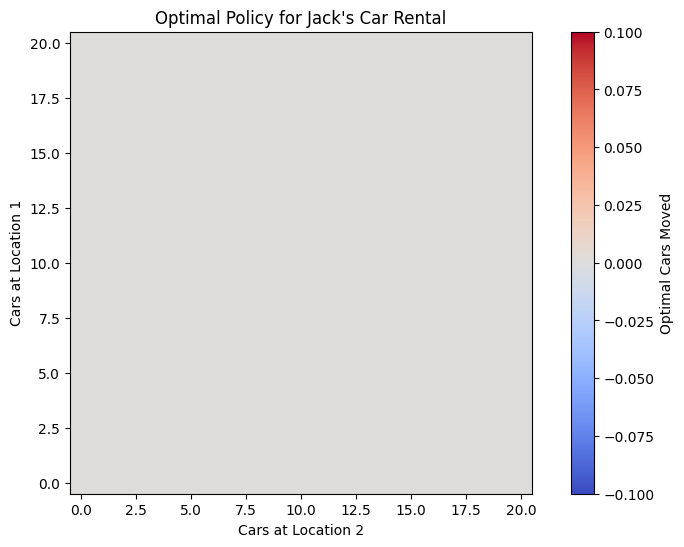

In [19]:
# Run policy iteration
optimal_policy, optimal_V = policy_iteration(env)

# Plot the optimal policy
plt.figure(figsize=(10, 6))
plt.imshow(optimal_policy, cmap="coolwarm", origin="lower")
plt.colorbar(label="Optimal Cars Moved")
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.title("Optimal Policy for Jack's Car Rental")
plt.show()


In [25]:
import numpy as np

n_state = 10
n_action = 5

V = np.zeros(n_state)

policy = np.ones((n_state, n_action))/n_action

def transitions(state, action):
    probs = np.random.randint(0,3)
    demands = 0
    if probs == 0:
        demands += 0.1
    elif probs == 1:
        demands += 0.3
    elif probs == 2:
        demands += 0.4
    else:
        demands += 0.2

    unit_sold = 3
    per_unit_ordered = 1
    leftover_inventory = 0.5

    reward=((unit_sold*3)-(per_unit_ordered*1)-(leftover_inventory*0.5))

    next_state = min(max(state + action, 0), n_state - 1)

    new_inventory = min(n_state + per_unit_ordered - demands, 10)

    return [(new_inventory, reward, next_state)]
            
    

def policy_evaluation(V, policy, theta=1e-5,gamma=0.9):
    while True:
        delta = 0

        for s in range(n_state):
            v = V[s]
            v_new = 0

            for a, action_prob in enumerate(policy[s]):
                trans = transitions(s, a - (n_action//2))
                for prob, reward, next_s in trans:
                    
                    v_new += prob * action_prob * (reward + gamma * V[next_s])
                
            V[s] = v_new
            delta = max(delta, abs(v_new - v))
            
        if delta < theta:
            break

    return V
                

print(policy_evaluation(V, policy))

[inf inf inf inf inf inf inf inf inf inf]


/tmp/ipykernel_120736/26010548.py:48: RuntimeWarning: overflow encountered in scalar add
  v_new += prob * action_prob * (reward + gamma * V[next_s])
/tmp/ipykernel_120736/26010548.py:51: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(v_new - v))


In [24]:
def move_zeroes(nums):
    k = len(nums) - 1 
    for i in range(len(nums)-1,-1,-1):
        if nums[i] != 0:
            nums[k] = nums[i]
            k -= 1
    for i in range(k+1):
        nums[i] = 0

    return nums

num = [0,1,0,3,12]

print(move_zeroes(num))

[0, 0, 1, 3, 12]


In [ ]:
# Input: s = "ab#c", t = "ad#c"
# Output: True → both become "ac"

def backspace_compare(s, t):

    for i in range(len(s)):
        if s[i]


In [42]:
word = "he#lo"
stack = []
for i in word:
    if i == '#':
        if stack:
            stack.pop()
    else:
        stack.append(i)

print("".join(stack))

hlo


In [1]:
sum = 0
for i in range(1, 101):
    sum += i
print(sum)


5050


In [4]:
a = [1, 2, 3]
b = a
b.append(4)
print(a)




[1, 2, 3, 4]


In [9]:
num = [2,3,4,5,9]
target = 5
# for i in range(len(num)):
#     for j in range(i + 1, len(num)):
#         print(i, j)
#         if num[j] == target - num[i]:
#             print([i, j])

# hashmap = {}
# for i in range(len(num)):
#     hashmap[num[i]] = i
# for i in range(len(num)):
#     complement = target - num[i]
#     if complement in hashmap and hashmap[complement] != i:
#         print([i, hashmap[complement]])

hashmap = {}
for i in range(len(num)):
    complement = target - num[i]
    if complement in hashmap:
        print([i, hashmap[complement]])
    hashmap[num[i]] = i
     

[1, 0]


In [11]:
height = [1,8,6,2,5,4,8,3,7]
max_area = 0

for i in range(len(height)):
    for j in range(i + 1, len(height)):
        width = j - i
        h = min(height[i], height[j])
        area = width * h
        max_area = max(max_area, area)
print(max_area)

49


In [23]:
nums = [-1,0,1,2,-1,-4]
triplets = []
for i in range(len(nums)):
    for j in range(i + 1, len(nums)):
        for k in range(j + 1, len(nums)):
            #print(i,j,k)
            if nums[i] + nums[j] + nums[k] == 0:
                triplet = sorted([nums[i], nums[j], nums[k]])
                if triplet not in triplets:
                    triplets.append(triplet)
print(triplets)

[[-1, 0, 1], [-1, -1, 2]]


In [27]:
def threeSum(nums):
    res = []
    nums.sort()
    for i, a in enumerate(nums):
        if i>0 and nums[i] == nums[i - 1]:
            continue
        l, r = i + 1, len(nums) -1
        while l < r:
            threesum = a + nums[l] + nums[r]
            if threesum < 0:
                l += 1
            elif threesum > 0:
                r -= 1
            else:
                res.append([a, nums[l], nums[r]])
                l += 1
                while l < r and nums[l] == nums[l - 1]:
                    l += 1
    return res

nums = [-1,0,1,2,-1,-4]
threeSum(nums)
  

[[-1, -1, 2], [-1, 0, 1]]

In [60]:
def threeSumClosest(nums, target):
    n = len(nums)
    closest_sum = float('inf')
    # for i in range(n-2):
    #     for j in range(i + 1, n - 1):
    #         for k in range(j + 1, n):
    #             total = nums[i] + nums[j] + nums[k]
    #             if abs(total - target) < abs(closest_sum - target):
    #                 closest_sum = total 
    # return closest_sum

    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                total = nums[i] + nums[j] + nums[k]
                if abs(total - target) < abs(closest_sum - target):
                    closest_sum = total 
    return closest_sum

nums = [-1,2,1,-4]
target = 1
threeSumClosest(nums, target)

2

In [59]:
def threeSumClosest(nums, target):
    nums.sort()
    closest_sum = float('inf')

    for i in range(len(nums) - 2):
        left, right = i + 1, len(nums) - 1

        while left < right:
            curr_sum = nums[i] + nums[left] + nums[right]

            # Update the closest sum if the current one is better
            if abs(curr_sum - target) < abs(closest_sum - target):
                closest_sum = curr_sum

            if curr_sum < target:
                left += 1
            elif curr_sum > target:
                right -= 1
            else:
                return curr_sum  # Exact match

    return closest_sum

nums = [-1,2,1,-4]
target = 1
threeSumClosest(nums, target)


2

In [62]:
value = set()
value.add((44,5,6,7,5))
print(value)

{(44, 5, 6, 7, 5)}


In [70]:

def fourSum(nums, target):
    """
    :type nums: List[int]
    :type target: int
    :rtype: List[List[int]]
    """
    # from itertools import combinations
    # seen = set()
    # for i in range(len(nums)):
    #     for j in range(i + 1, len(nums)):
    #         for k in range(j +1, len(nums)):
    #             for m in range(k+1, len(nums)):
    #                 total = nums[i] + nums[j] + nums[k] + nums[m]
    #                 if total == target:
    #                     quad = tuple(sorted([nums[i], nums[j], nums[k], nums[m]]))
    #                     seen.add(quad)

    # return [list(q) for q in seen]

    nums.sort()
    result = []
    for i in range(len(nums)):
        if i > 0 and nums[i] == nums[i - 1]:
            continue

        for j in range(i + 1, len(nums)):
            if j > i + 1 and nums[j] == nums[j - 1]:
                continue

            l, r = j + 1, len(nums) - 1

            while l < l:
                total = nums[i] + nums[j] + nums[l] + nums[r]

                if total < target:
                    l += 1
                elif total > target:
                    r -= 1
                else:
                    result.append([[nums[i], nums[j], nums[l], nums[r]]])
                    l += 1
                    r -= 1

                    while l < r and nums[l] == nums[l - 1]:
                        l += 1
                    while l < r and nums[r] == nums[r + 1]:
                        r -= 1

    return result

            
# nums = [1,0,-1,0,-2,2]
# target = 0
nums = [2,2,2,2,2]
target = 8
fourSum(nums, target)
        

[]

In [ ]:

def removeElement(nums, val):
    """
    :type nums: List[int]
    :type val: int
    :rtype: int
    """
    k = 0
    for i in range(len(nums)):
        if nums[i] == val:
            k += 1
            nums[i] = nums[val]
    return k
    
nums = [3,2,2,3]
val = 3
removeElement(nums, val)

(2, [3, 2, 2, 3])

In [82]:
def reverse(char):
    char = list(char)
    left = 0
    right = len(char) - 1

    while left < right:
        char[left], char[right] = char[right], char[left] 
        left += 1
        right -=1

    return "".join(char)

char = "hello"
reverse(char)

'olleh'

In [91]:
def zeroMoving(arr):
    if not arr:
        return None
    
    left = 0
    for i in range(len(arr)):
        if arr[i] != 0:
            arr[left] = arr[i]
            left += 1
     
    for j in range(left, len(arr)):
        arr[j] = 0

    return arr

arr = [0,1,0,3,12]
zeroMoving(arr)

[1, 3, 12, 0, 0]

In [95]:
def waterArea(height):

    left = 0
    right = len(height) -1
    max_area = 0
    while left < right:
        area = min(height[left], height[right]) * (right - left)
        max_area = max(area, max_area)
        if height[left] < height[right]:
            left += 1
        else:
            right -= 1

    return max_area

height = [1,8,6,2,5,4,8,3,7]
waterArea(height)

49

In [97]:
def trapRainWater(height):
    l, r = 0, len(height) - 1
    water_trapped = 0
    left_max = height[l]
    right_max = height[r]

    while l < r:
        if left_max < right_max:
            l += 1
            left_max = max(left_max, height[l])
            water_trapped += left_max - height[l]
        else:
            right -= 1
            right_max = max(right_max, height[r])
            water_trapped += right_max - height[r]

    return water_trapped

height = [0,1,2,0,1,1,0,2,3]
trapRainWater(height)



6

In [17]:
def count_characters(s):
    hashmap = {}
    for i in range(len(s)):
        hashmap[s[i]] = 1 + hashmap.get(s[i], 0)
    return hashmap
print(count_characters("banana"))

{'b': 1, 'a': 3, 'n': 2}


In [ ]:
def firstUnique(s):
    hashmap = {}

    for i in range(len(s)):
        hashmap[s[i]] =1 + hashmap.get(s[i], 0)
    print(hashmap)
    for i in range(len(s)):
        if hashmap[s[i]] == 1:
            return i
        
    return -1
        
s = "aabb"

print(firstUnique(s))

{'a': 2, 'b': 2}
-1


In [44]:
def groupAnagrams(s):
    hashmap = {}
    for word in s:
        key = tuple(sorted(word))
        
        if key not in hashmap:
            hashmap[key] = []
        
        hashmap[key].append(word)

    return list(hashmap.values())

groupAnagrams(["eat", "tea", "tan", "ate", "nat", "bat"])

[['eat', 'tea', 'ate'], ['tan', 'nat'], ['bat']]

In [52]:
def groupAnagrams(strs):
    from collections import defaultdict

    hashmap = defaultdict(list)

    for word in strs:
        # Count characters (26 letters, assuming lowercase)
        count = [0] * 26
        for char in word:
            count[ord(char) - ord('a')] += 1

        key = tuple(count)
        hashmap[key].append(word)
    #print(count)
    #print(key)
    return list(hashmap.values())

groupAnagrams(["eat", "tea", "tan", "ate", "nat", "bat"])

[['eat', 'tea', 'ate'], ['tan', 'nat'], ['bat']]

In [56]:
from collections import defaultdict

def kMostFrequent(nums, k):
    if len(nums) == 1 and k == 1:
        return nums
    
    hashmap = {}
    for i in range(len(nums)):
        hashmap[nums[i]] =1 + hashmap.get(nums[i], 0)
    
    bucket = [[] for _ in range(len(nums) + 1)]
    for num, count in hashmap.items():
        bucket[count].append(num)

    result = []
    for i in range(len(bucket)-1,0,-1):
        for num in bucket[i]:
            result.append(num)
            if len(result) == k:
                return result
    
    
nums = [1,1,1,2,2,3] 
k = 2
kMostFrequent(nums, k)

[1, 2]

In [68]:
def topKFrequent(nums, k):
    count = {}
    freq = [[] for _ in range(len(nums) + 1)]

    for n in nums:
        count[n] = 1 + count.get(n, 0)
    print(count)
    print(freq)

    for c, n in count.items():
        freq[c].append(n)
        print(c, n)
    print(freq)

    res = []
    for i in range(len(freq)-1,0,-1):
        for n in freq[i]:
            print(n)
            res.append(n)
            if len(res) == k:
                return res
    

nums = [1,1,1,2,2,3]
k = 2
topKFrequent(nums, k)

{1: 3, 2: 2, 3: 1}
[[], [], [], [], [], [], []]
1 3
2 2
3 1
[[], [3], [2], [1], [], [], []]
1
2


[1, 2]

In [70]:
def mostFrequentChar(s):
    count = {}
    freq = [[] for _ in range(len(s) + 1)]
    for n in s:
        count[n] = count.get(n, 0) + 1


    max_freq = 0
    result = ''

    for c, n in count.items():
        if n > max_freq:
            max_freq = n
            result = c

    return result 
         
s = "mississippi"
mostFrequentChar(s)

'i'

In [75]:
def productExceptSelf(nums):
    n = len(nums)
    res = [0]*n
    pref = [0]*n
    surf = [0]*n

    pref[0] = surf[n-1] = 1
    for i in range(1, n):
        pref[i] = nums[i - 1] * pref[i - 1]

    for i in range(n-2,-1,-1):
        surf[i] = nums[i + 1] * surf[i + 1]

    for i in range(n):
        res[i] = pref[i] * surf[i]

    return res

nums = [1,2,3,4] 
productExceptSelf(nums)

[24, 12, 8, 6]

In [79]:

def productExceptSelf(nums):
    res = [1] * (len(nums))
    print(res)

    prefix = 1
    for i in range(len(nums)):
        res[i] = prefix
        print(res)
        prefix *= nums[i]
        print(res) 
        print(prefix)
    postfix = 1
    for i in range(len(nums) - 1, -1, -1):
        res[i] *= postfix
        postfix *= nums[i]
        print(res)
        print(postfix)
    return res
    
nums = [1,2,3,4] 
productExceptSelf(nums)

[1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1]
1
[1, 1, 1, 1]
[1, 1, 1, 1]
2
[1, 1, 2, 1]
[1, 1, 2, 1]
6
[1, 1, 2, 6]
[1, 1, 2, 6]
24
[1, 1, 2, 6]
4
[1, 1, 8, 6]
12
[1, 12, 8, 6]
24
[24, 12, 8, 6]
24


[24, 12, 8, 6]

In [82]:
def productExceptSelf(nums):
    n = len(nums)
    res = []

    for i in range(n):
        prod = 1
        for j in range(n):
            if i != j:
                prod *= nums[j]
        res.append(prod)

    return res

nums = [1,2,3,4] 
productExceptSelf(nums)

[24, 12, 8, 6]

In [84]:
def productExceptSelf(nums):
    total_product = 1
    zero_count = nums.count(0)

    if zero_count > 1:
        return [0] * len(nums)
    
    for num in nums:
        if num != 0:
            total_product *= num

    res = []
    for num in nums:
        if zero_count == 0:
            res.append(total_product // num)
        else:
            res.append(0 if num != 0 else total_product)
    
    return res

nums = [1,2,3,4] 
productExceptSelf(nums)


[24, 12, 8, 6]

In [86]:
res = [1] * len(nums)

prefix = 1
for i in range(len(nums)):
    res[i] = prefix
    prefix *= nums[i]

print(prefix, res)

24 [1, 1, 2, 6]


In [89]:
class DynamicArray:
    def __init__(self):
        self.capacity = 1
        self.length = 0
        self.array = self._make_array(self.capacity)

    def _make_array(self, capacity):
        return [None]*capacity
    
    def append(self, item):
        if self.length == self.capacity:
            self._resize(2 * self.capacity)
        self.array[self.length] = item
        self.length += 1

    def _resize(self, new_capacity):
        new_array = self._make_array(new_capacity)
        for i in range(self.length):
            new_array[i] = self.array[i]
        self.array = new_array
        self.capacity = new_capacity

    def __getitem__(self, index):
        if 0 <= index < self.length:
            return self.array[index]
        raise IndexError("Index out of bound")
    
    def __len__(self):
        return self.length
    
    def pop(self):
        if self.length == 0:
            raise IndexError("Pop from empty array")
    
        item = self.array[self.length - 1]
        self.array[self.length - 1] = None
        self.length -= 1

        # Shrink if length is less than 1/4th of capacity
        if 0 < self.length < self.capacity // 4:
            self._resize(self.capacity // 2)

        return item

    
# arr = DynamicArray()
# for i in range(10):
#     arr.append(i)
#     print(f"Added {i}, Length: {len(arr)}, Capacity: {arr.capacity}")

arr = DynamicArray()
for i in range(16):
    arr.append(i)

for _ in range(14):
    print(f"Popped: {arr.pop()}, Length: {len(arr)}, Capacity: {arr.capacity}")



Popped: 15, Length: 15, Capacity: 16
Popped: 14, Length: 14, Capacity: 16
Popped: 13, Length: 13, Capacity: 16
Popped: 12, Length: 12, Capacity: 16
Popped: 11, Length: 11, Capacity: 16
Popped: 10, Length: 10, Capacity: 16
Popped: 9, Length: 9, Capacity: 16
Popped: 8, Length: 8, Capacity: 16
Popped: 7, Length: 7, Capacity: 16
Popped: 6, Length: 6, Capacity: 16
Popped: 5, Length: 5, Capacity: 16
Popped: 4, Length: 4, Capacity: 16
Popped: 3, Length: 3, Capacity: 8
Popped: 2, Length: 2, Capacity: 8


In [93]:
class DynamicArray:
    def __init__(self):
        self.capacity = 1
        self.length = 0
        self.array = self._make_array(self.capacity)

    def _make_array(self, capacity):
        return [None]*capacity

    def append(self, x):
        if self.length == self.capacity:
            self._resize(2*self.capacity)
        self.array[self.length] = x
        self.length += 1

    def _resize(self, new_capacity):
        new_array = self._make_array(new_capacity)
        for i in range(self.length):
            new_array[i] = self.array[i]
        self.array = new_array
        self.capacity = new_capacity

    def pop(self):
        if self.length == 0:
            raise IndexError("Pop form an empty array")
        item = self.array[self.length-1]
        self.array[self.length - 1] = None
        self.length -= 1

        if 0 < self.length < self.capacity // 4:
            self._resize(self.capacity // 2)
        return item
    
    def print_array(self):
        print(f"Array: {self.array}, Length: {self.length}, Capacity: {self.capacity}")

    def get_median(self):
        if self.length == 0:
            return None
        
        filled = self.array[:self.length]
        sorted_arr = sorted(filled)

        mid = self.length // 2
        if self.length % 2 == 0:
            return (sorted_arr[mid-1] + sorted_arr[mid]) /2 
        else:
            return sorted_arr[mid]

     

arr = DynamicArray()

# Sample operations
ops = [
    "append 1", "append 2", "append 3", "append 4",
    "append 5", "append 6", "pop", "pop", "append 7", "print"
]

for op in ops:
    if op.startswith("append"):
        _, x = op.split()
        arr.append(int(x))
    elif op == "pop":
        arr.pop()
    elif op == "print":
        arr.print_array()


Array: [1, 2, 3, 4, 7, None, None, None], Length: 5, Capacity: 8


In [94]:
arr = DynamicArray()
arr.append(3)
arr.append(1)
arr.append(5)
print(arr.get_median())  # Output: 3

arr.append(2)
print(arr.get_median())  # Output: (2 + 3) / 2 = 2.5


3
2.5


In [ ]:
#Challenge 1: largest Number
def largerstNum(nums):
    max_num = 0
    for i in range(len(nums)):
        if nums[i] > max_num:
            max_num = nums[i]
    return max_num

nums = [1,2,5,8,7,9]
largerstNum(nums)

9

In [101]:
#Challenge 2: FizzBuzz
def fizzBuzz():
    for i in range(1, 21):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)

fizzBuzz()

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16
17
Fizz
19
Buzz


In [102]:
#Challenge 3: Palindrome
def palindrome(s):
    return s == s[::-1]

print(palindrome("radar"))  # True
print(palindrome("python"))  # False


True
False


In [105]:
#Challenge 4: Count Vowels
def countVowels(strs):
    vowels = ['a','e','i','o','u']
    counts = 0
    for i in strs.lower():
        if i in vowels:
            counts += 1
    return counts

print(countVowels("Hello, HOW are You?")) 

7


In [18]:
board = [["1","2",".",".","3",".",".",".","."],
 ["4",".",".","5",".",".",".",".","."],
 [".","9","8",".",".",".",".",".","3"],
 ["5",".",".",".","6",".",".",".","4"],
 [".",".",".","8",".","3",".",".","5"],
 ["7",".",".",".","2",".",".",".","6"],
 [".",".",".",".",".",".","2",".","."],
 [".",".",".","4","1","9",".",".","8"],
 [".",".",".",".","8",".",".","7","9"]]
from collections import defaultdict

def isValidSudoku(board):
    for row in range(9):
        seen = set()
        for i in range(9):
            if board[row][i] == ".": 
                continue
            if board[row][i] in seen:
                return False
            seen.add(board[row][i])

    for col in range(9):
        seen = set()
        for i in range(9):
            if board[i][col] == ".":
                continue
            if board[i][col] in seen:
                return False
            seen.add(board[i][col])

    for square in range(9):
        seen = set()
        for i in range(3):
            for j in range(3):
                row = (square//3) * 3 + i
                col = (square % 3) * 3 + j
                if board[row][col] == ".":
                    continue
                if board[row][col] in seen:
                    return False
                seen.add(board[row][col])
    return True

isValidSudoku(board)

True

In [19]:

def isValidSudoku(board):
    rows = [set() for _ in range(9)]
    cols = [set() for _ in range(9)]
    boxes = [set() for _ in range(9)]  # 3x3 sub-boxes

    for i in range(9):
        for j in range(9):
            num = board[i][j]

            if num == '.':
                continue

            # Check row
            if num in rows[i]:
                return False
            rows[i].add(num)

            # Check column
            if num in cols[j]:
                return False
            cols[j].add(num)

            # Check 3x3 box
            box_index = (i // 3) * 3 + (j // 3)
            if num in boxes[box_index]:
                return False
            boxes[box_index].add(num)

    return True

isValidSudoku(board)

True